# Notebook to train a NN for repairing pose estimation

In [1]:
# imports

import paths
import numpy as np
import functions_bondjango as bd
import pandas as pd
import processing_parameters
import os
from snakemake_scripts.sub_preprocess_S1 import process_corners
import random
import functions_plotting as fp
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
# load the data

# define the likelihood threshold for the DLC points
likelihood_threshold = 0.8

# define the search string
search_string = processing_parameters.search_string

# define the target model
if 'miniscope' in search_string:
    target_model = 'video_experiment'
else:
    target_model = 'vr_experiment'

# get the queryset
file_set = bd.query_database(target_model, search_string)

# allocate memory to accumulate the trajectories
all_points = []

# run through the files
for files in file_set:
    raw_path = files['bonsai_path']
    calcium_path = files['bonsai_path'][:-4] + '_calcium.hdf5'

    file_path_dlc = files['bonsai_path'].replace('.csv', '_dlc.h5')
    # load the bonsai info
    raw_h5 = pd.read_hdf(file_path_dlc)
    # get the column names
    column_names = raw_h5.columns
    # take only the relevant columns
    # DLC in small arena
    filtered_traces = pd.DataFrame(raw_h5[[
        [el for el in column_names if ('mouseSnout' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseSnout' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBarL' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBarL' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBarR' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBarR' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseHead' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseHead' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBody1' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBody1' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBody2' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBody2' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBody3' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBody3' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBase' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBase' in el) and ('y' in el)][0],
        [el for el in column_names if ('cricketHead' in el) and ('x' in el)][0],
        [el for el in column_names if ('cricketHead' in el) and ('y' in el)][0],
        [el for el in column_names if ('cricketBody' in el) and ('x' in el)][0],
        [el for el in column_names if ('cricketBody' in el) and ('y' in el)][0],
    ]].to_numpy(), columns=['mouse_snout_x', 'mouse_snout_y', 'mouse_barl_x', 'mouse_barl_y',
                            'mouse_barr_x', 'mouse_barr_y', 'mouse_head_x', 'mouse_head_y',
                            'mouse_x', 'mouse_y', 'mouse_body2_x', 'mouse_body2_y',
                            'mouse_body3_x', 'mouse_body3_y', 'mouse_base_x', 'mouse_base_y',
                            'cricket_0_head_x', 'cricket_0_head_y', 'cricket_0_x', 'cricket_0_y'])

    # get the likelihoods
    likelihood_frame = pd.DataFrame(raw_h5[[
        [el for el in column_names if ('mouseHead' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBody1' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBody2' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBody3' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBase' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('cricketHead' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('cricketBody' in el) and ('likelihood' in el)][0],
    ]].to_numpy(), columns=['mouse_head', 'mouse', 'mouse_body2',
                            'mouse_body3', 'mouse_base',
                            'cricket_0_head', 'cricket_0'])

    # nan the trace where the likelihood is too low
    # for all the columns
    for col in likelihood_frame.columns:
        # get the vector for nans
        nan_vector = likelihood_frame[col] < likelihood_threshold
        # nan the points
        filtered_traces.loc[nan_vector, col+'_x'] = np.nan
        filtered_traces.loc[nan_vector, col+'_y'] = np.nan

    corner_info = pd.DataFrame(raw_h5[[
        [el for el in column_names if ('corner_UL' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_UL' in el) and ('y' in el)][0],
        [el for el in column_names if ('corner_BL' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_BL' in el) and ('y' in el)][0],
        [el for el in column_names if ('corner_BR' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_BR' in el) and ('y' in el)][0],
        [el for el in column_names if ('corner_UR' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_UR' in el) and ('y' in el)][0],
    ]].to_numpy(), columns=['corner_UL_x', 'corner_UL_y', 'corner_BL_x', 'corner_BL_y',
                            'corner_BR_x', 'corner_BR_y', 'corner_UR_x', 'corner_UR_y'])
    # get the corners
    corner_points = process_corners(corner_info)

    # accumulate the points
    all_points.append(filtered_traces)

In [3]:
# Prepare the data

# define the amount of delay to include
delay = 4
# define the learning rate
learning_rate = 0.001
# define the test train split
validation_split = 0.2
# get the target column names
column_list = [el for el in all_points[0].columns if ('mouse' in el) and ('_x' in el)]
column_list += [el for el in all_points[0].columns if ('mouse' in el) and ('_y' in el)]
# get the number of features
number_features = len(column_list)
# allocate memory for the data
data_matrix = []

# for all the files
for files in all_points:
    # select the features to use
    current_points = np.array(files.loc[:, column_list])
    # get the number of timepoints
    number_timepoints = current_points.shape[0]

    # allocate memory for the design matrix
    design_matrix = np.zeros((number_timepoints, number_features*delay + number_features))
    # pad the data according to the delay
    current_points = np.concatenate((np.zeros((delay, number_features)), current_points), axis=0)
    # assemble the design matrix
    # for all the points
    for points in np.arange(number_timepoints):
        design_matrix[points, :] = current_points[points:points+delay+1, :].reshape([1, -1])
    # save
    data_matrix.append(design_matrix)

# concatenate the data
data_matrix = np.concatenate(data_matrix, axis=0)

# # get a vector with the rows with NaN
# nan_vector = np.any(np.isnan(data_matrix), axis=1)

# get a vector with only the y rows that have nans
nan_vector = np.any(np.isnan(data_matrix[:, :number_features]), axis=1)

# eliminate the points with NaNs in them
nonan_matrix = data_matrix[~nan_vector, :]
nan_matrix = data_matrix[nan_vector, :]

# # normalize to pixel size
# nonan_matrix = nonan_matrix/1280
# separate the fitting data and the target
# X = nonan_matrix[:, number_features:]
# y = nonan_matrix[:, :number_features]

# make nans -1
nonan_matrix[np.isnan(nonan_matrix)] = 0

X = nonan_matrix[:, number_features:]
y = nonan_matrix[:, :number_features]

# generate random 0s in the matrix
random_zero = np.random.rand(*X.shape)
random_zero = random_zero>0.5
X[random_zero] = 0

# shuffle the data
shuffle_idx = tf.random.shuffle(np.arange(X.shape[0]))
X = X[shuffle_idx, :]
y = y[shuffle_idx, :]

print(X.shape)

# normalize
# X = tf.keras.utils.normalize(X, axis=1)
# y = tf.keras.utils.normalize(y, axis=1)

# split into training and test sets

# get a selection vector based on the number of points and the desired split
validation_idx = random.sample(list(np.arange(X.shape[0])), 
                               np.int(np.round(validation_split*X.shape[0])))
# print(validation_idx)
validation_vector = np.zeros([X.shape[0]])
validation_vector[validation_idx] = 1
validation_vector = validation_vector == 1
train_vector = ~validation_vector

train_X = X[train_vector, :]
train_y = y[train_vector, :]

validation_X = X[validation_vector, :]
validation_y = y[validation_vector, :]

# reshape the data
# train_X = train_X.reshape([-1, len(column_list)/2, 2])

# print(train_X[:10, 0])
# print(validation_X[:10, 0])

print(train_X.shape)
print(validation_X.shape)
print(column_list)
# # normalize
# train_X = tf.keras.utils.normalize(train_X, axis=1)
# train_y = tf.keras.utils.normalize(train_y, axis=1)
# validation_X = tf.keras.utils.normalize(validation_X, axis=1)
# validation_y = tf.keras.utils.normalize(validation_y, axis=1)

(407049, 64)
(325639, 64)
(81410, 64)
['mouse_snout_x', 'mouse_barl_x', 'mouse_barr_x', 'mouse_head_x', 'mouse_x', 'mouse_body2_x', 'mouse_body3_x', 'mouse_base_x', 'mouse_snout_y', 'mouse_barl_y', 'mouse_barr_y', 'mouse_head_y', 'mouse_y', 'mouse_body2_y', 'mouse_body3_y', 'mouse_base_y']


In [4]:
# Create and visualize the network

# create the network
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=[train_X.shape[1], ]))
# model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
Total params: 5,200
Trainable params: 5,200
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Fit the network

# model.fit(X, y, validation_split=validation_split, batch_size=256, epochs=500, shuffle=True, verbose=2)
# model.fit(train_X, train_y, validation_split=validation_split, batch_size=256, epochs=500, shuffle=True, verbose=2)
model.fit(train_X, train_y, validation_data=(validation_X, validation_y), 
          batch_size=256, epochs=500, shuffle=True, verbose=2)


Epoch 1/500
1273/1273 - 1s - loss: 34220.5664 - val_loss: 21312.0332
Epoch 2/500
1273/1273 - 1s - loss: 15685.6553 - val_loss: 11641.5088
Epoch 3/500
1273/1273 - 1s - loss: 9364.5605 - val_loss: 7917.8447
Epoch 4/500
1273/1273 - 1s - loss: 7105.1772 - val_loss: 6769.6875
Epoch 5/500
1273/1273 - 1s - loss: 6370.4170 - val_loss: 6145.9175
Epoch 6/500
1273/1273 - 1s - loss: 5816.4658 - val_loss: 5868.5264
Epoch 7/500
1273/1273 - 1s - loss: 5272.2856 - val_loss: 5136.1987
Epoch 8/500
1273/1273 - 1s - loss: 4720.7461 - val_loss: 4484.8247
Epoch 9/500
1273/1273 - 1s - loss: 4347.4629 - val_loss: 4337.6602
Epoch 10/500
1273/1273 - 1s - loss: 4169.4526 - val_loss: 4164.6597
Epoch 11/500
1273/1273 - 1s - loss: 4032.4692 - val_loss: 4104.4795
Epoch 12/500
1273/1273 - 1s - loss: 3891.4541 - val_loss: 3773.0300
Epoch 13/500
1273/1273 - 1s - loss: 3696.4653 - val_loss: 3955.0310
Epoch 14/500
1273/1273 - 1s - loss: 3596.5403 - val_loss: 3882.7332
Epoch 15/500
1273/1273 - 1s - loss: 3543.6191 - val_l

Epoch 122/500
1273/1273 - 1s - loss: 2975.6846 - val_loss: 3108.8799
Epoch 123/500
1273/1273 - 1s - loss: 2966.9094 - val_loss: 3320.2959
Epoch 124/500
1273/1273 - 1s - loss: 2971.5066 - val_loss: 3191.8120
Epoch 125/500
1273/1273 - 1s - loss: 2973.4927 - val_loss: 3030.2466
Epoch 126/500
1273/1273 - 1s - loss: 2970.1372 - val_loss: 3163.2134
Epoch 127/500
1273/1273 - 1s - loss: 2964.4194 - val_loss: 3101.0068
Epoch 128/500
1273/1273 - 1s - loss: 2964.2917 - val_loss: 3466.5603
Epoch 129/500
1273/1273 - 1s - loss: 2969.3811 - val_loss: 3153.6409
Epoch 130/500
1273/1273 - 1s - loss: 2965.4788 - val_loss: 3191.9495
Epoch 131/500
1273/1273 - 1s - loss: 2962.9646 - val_loss: 2977.4214
Epoch 132/500
1273/1273 - 1s - loss: 2962.3586 - val_loss: 3017.7026
Epoch 133/500
1273/1273 - 1s - loss: 2958.7871 - val_loss: 3022.4343
Epoch 134/500
1273/1273 - 1s - loss: 2957.9893 - val_loss: 2981.0273
Epoch 135/500
1273/1273 - 1s - loss: 2955.6929 - val_loss: 3001.1687
Epoch 136/500
1273/1273 - 1s - los

Epoch 241/500
1273/1273 - 1s - loss: 2800.5645 - val_loss: 3051.6162
Epoch 242/500
1273/1273 - 1s - loss: 2802.7671 - val_loss: 3190.7205
Epoch 243/500
1273/1273 - 1s - loss: 2806.1770 - val_loss: 2909.6611
Epoch 244/500
1273/1273 - 1s - loss: 2803.7922 - val_loss: 2910.3457
Epoch 245/500
1273/1273 - 1s - loss: 2798.7539 - val_loss: 3010.8669
Epoch 246/500
1273/1273 - 1s - loss: 2804.1331 - val_loss: 2965.5183
Epoch 247/500
1273/1273 - 1s - loss: 2798.2607 - val_loss: 3317.7024
Epoch 248/500
1273/1273 - 1s - loss: 2799.6985 - val_loss: 2994.6584
Epoch 249/500
1273/1273 - 1s - loss: 2795.0864 - val_loss: 3207.3682
Epoch 250/500
1273/1273 - 1s - loss: 2801.8770 - val_loss: 3103.6487
Epoch 251/500
1273/1273 - 1s - loss: 2795.9868 - val_loss: 2940.0964
Epoch 252/500
1273/1273 - 1s - loss: 2796.3130 - val_loss: 2903.6870
Epoch 253/500
1273/1273 - 1s - loss: 2794.8621 - val_loss: 2938.5212
Epoch 254/500
1273/1273 - 1s - loss: 2792.5583 - val_loss: 2987.4785
Epoch 255/500
1273/1273 - 1s - los

Epoch 360/500
1273/1273 - 1s - loss: 2646.4299 - val_loss: 2740.3350
Epoch 361/500
1273/1273 - 1s - loss: 2646.2451 - val_loss: 2794.4741
Epoch 362/500
1273/1273 - 1s - loss: 2640.1125 - val_loss: 2684.8064
Epoch 363/500
1273/1273 - 1s - loss: 2641.8140 - val_loss: 2813.7417
Epoch 364/500
1273/1273 - 1s - loss: 2646.2837 - val_loss: 2688.1960
Epoch 365/500
1273/1273 - 1s - loss: 2641.4863 - val_loss: 2695.3838
Epoch 366/500
1273/1273 - 1s - loss: 2647.6582 - val_loss: 2700.0720
Epoch 367/500
1273/1273 - 1s - loss: 2641.4075 - val_loss: 2849.0312
Epoch 368/500
1273/1273 - 1s - loss: 2642.3711 - val_loss: 2728.4685
Epoch 369/500
1273/1273 - 1s - loss: 2642.1326 - val_loss: 2728.3301
Epoch 370/500
1273/1273 - 1s - loss: 2640.6650 - val_loss: 2684.1189
Epoch 371/500
1273/1273 - 1s - loss: 2645.0576 - val_loss: 2789.7114
Epoch 372/500
1273/1273 - 1s - loss: 2640.1697 - val_loss: 2748.2185
Epoch 373/500
1273/1273 - 1s - loss: 2642.3550 - val_loss: 2763.8640
Epoch 374/500
1273/1273 - 1s - los

Epoch 479/500
1273/1273 - 1s - loss: 2556.1531 - val_loss: 2777.6526
Epoch 480/500
1273/1273 - 1s - loss: 2562.7517 - val_loss: 2776.6416
Epoch 481/500
1273/1273 - 1s - loss: 2554.8108 - val_loss: 2593.1938
Epoch 482/500
1273/1273 - 1s - loss: 2558.4580 - val_loss: 2914.7634
Epoch 483/500
1273/1273 - 1s - loss: 2555.5430 - val_loss: 2837.7688
Epoch 484/500
1273/1273 - 1s - loss: 2556.8518 - val_loss: 2606.5754
Epoch 485/500
1273/1273 - 1s - loss: 2555.1426 - val_loss: 2741.5891
Epoch 486/500
1273/1273 - 1s - loss: 2555.4878 - val_loss: 2877.8013
Epoch 487/500
1273/1273 - 1s - loss: 2555.5847 - val_loss: 2771.1191
Epoch 488/500
1273/1273 - 1s - loss: 2551.8845 - val_loss: 2814.7346
Epoch 489/500
1273/1273 - 1s - loss: 2555.8779 - val_loss: 3074.3721
Epoch 490/500
1273/1273 - 1s - loss: 2554.2754 - val_loss: 2724.1775
Epoch 491/500
1273/1273 - 1s - loss: 2554.1487 - val_loss: 2747.8645
Epoch 492/500
1273/1273 - 1s - loss: 2558.8760 - val_loss: 2728.2588
Epoch 493/500
1273/1273 - 1s - los

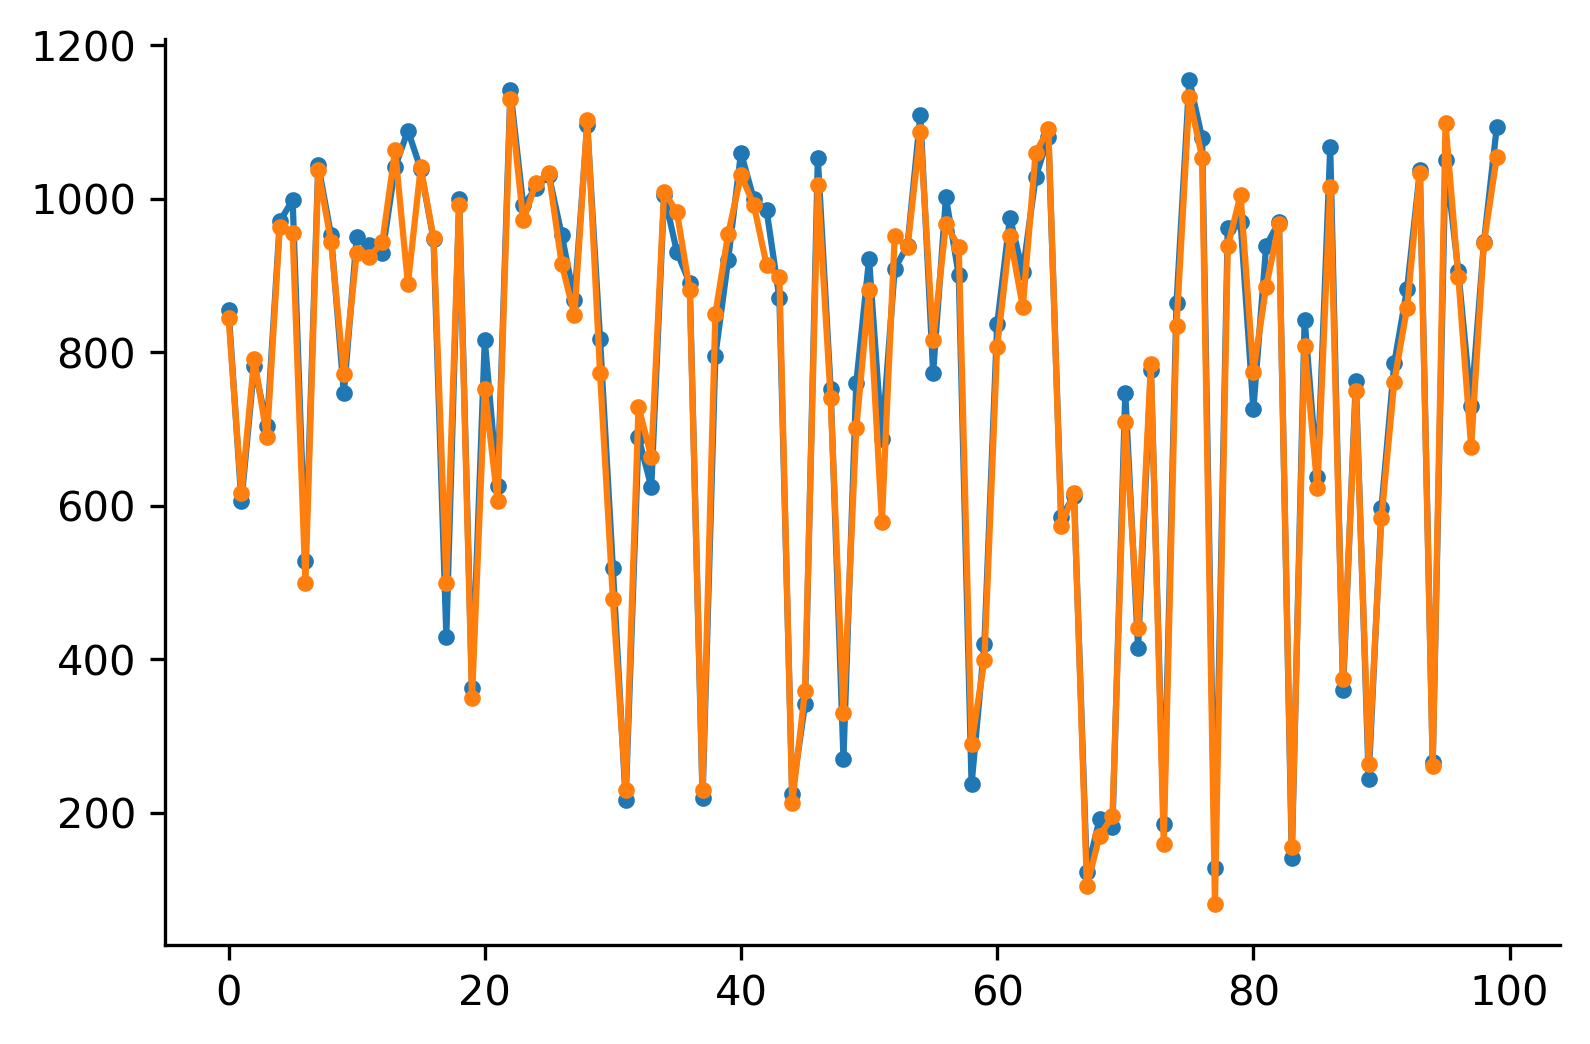

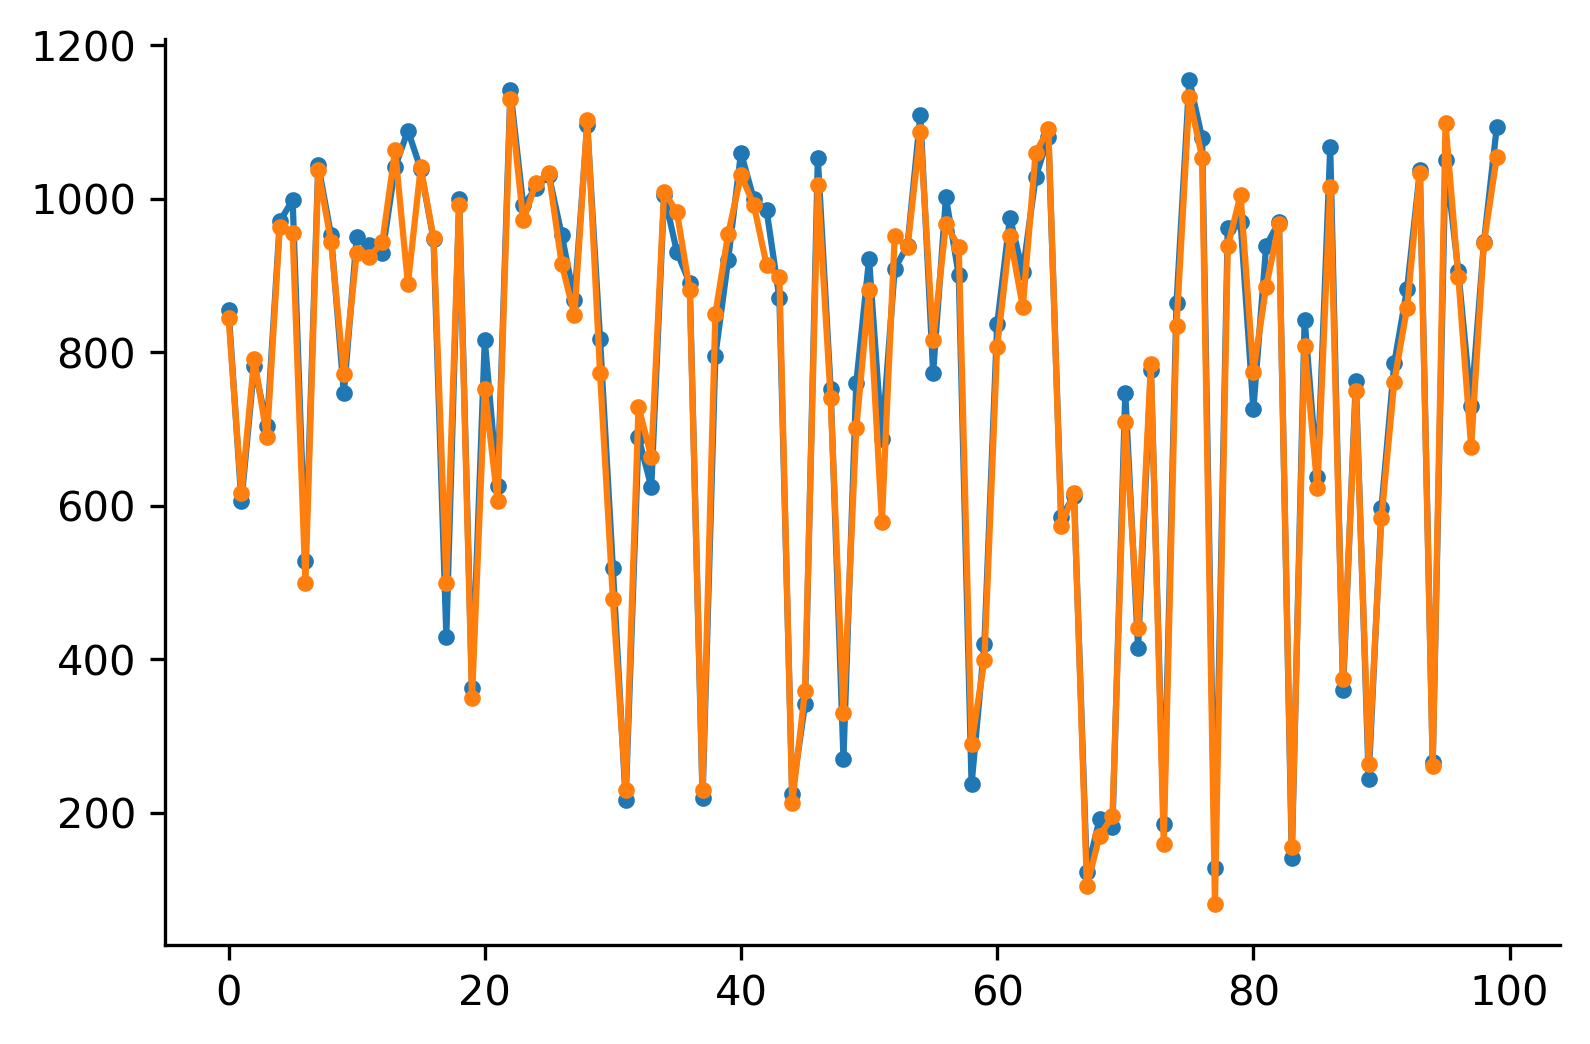

In [6]:
# Evaluate the network

# predicted_data = model.predict(X[-100:, :])

# fp.plot_2d([[y[-100:, 1], predicted_data[-100:, 1]]])

predicted_data = model.predict(validation_X[:100, :])

fp.plot_2d([[validation_y[:100, 1], predicted_data[:100, 1]]])

# predicted_data = model.predict(train_X[:100, :])

# fp.plot_2d([[train_y[:100, 1], predicted_data[:100, 1]]])

In [7]:
# Save the model

# get the path to save the model
save_path = paths.pose_repair_path

# save the model
model.save(save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: J:\Drago Guggiana Nilo\Prey_capture\Pose_repair\assets


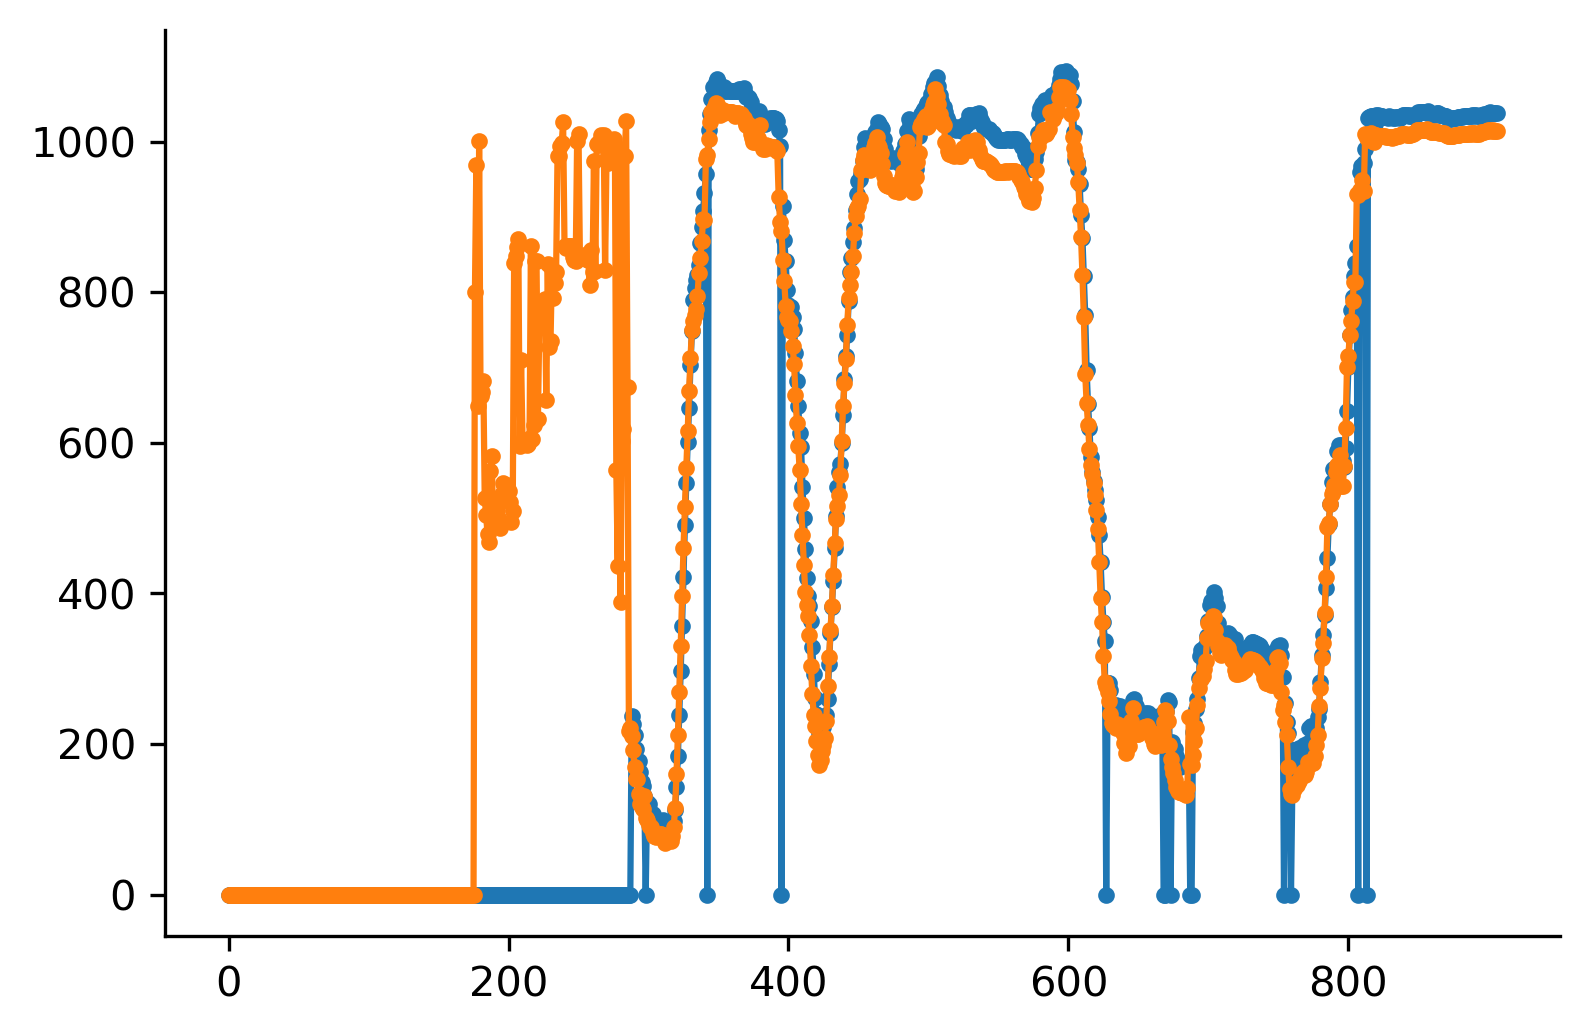

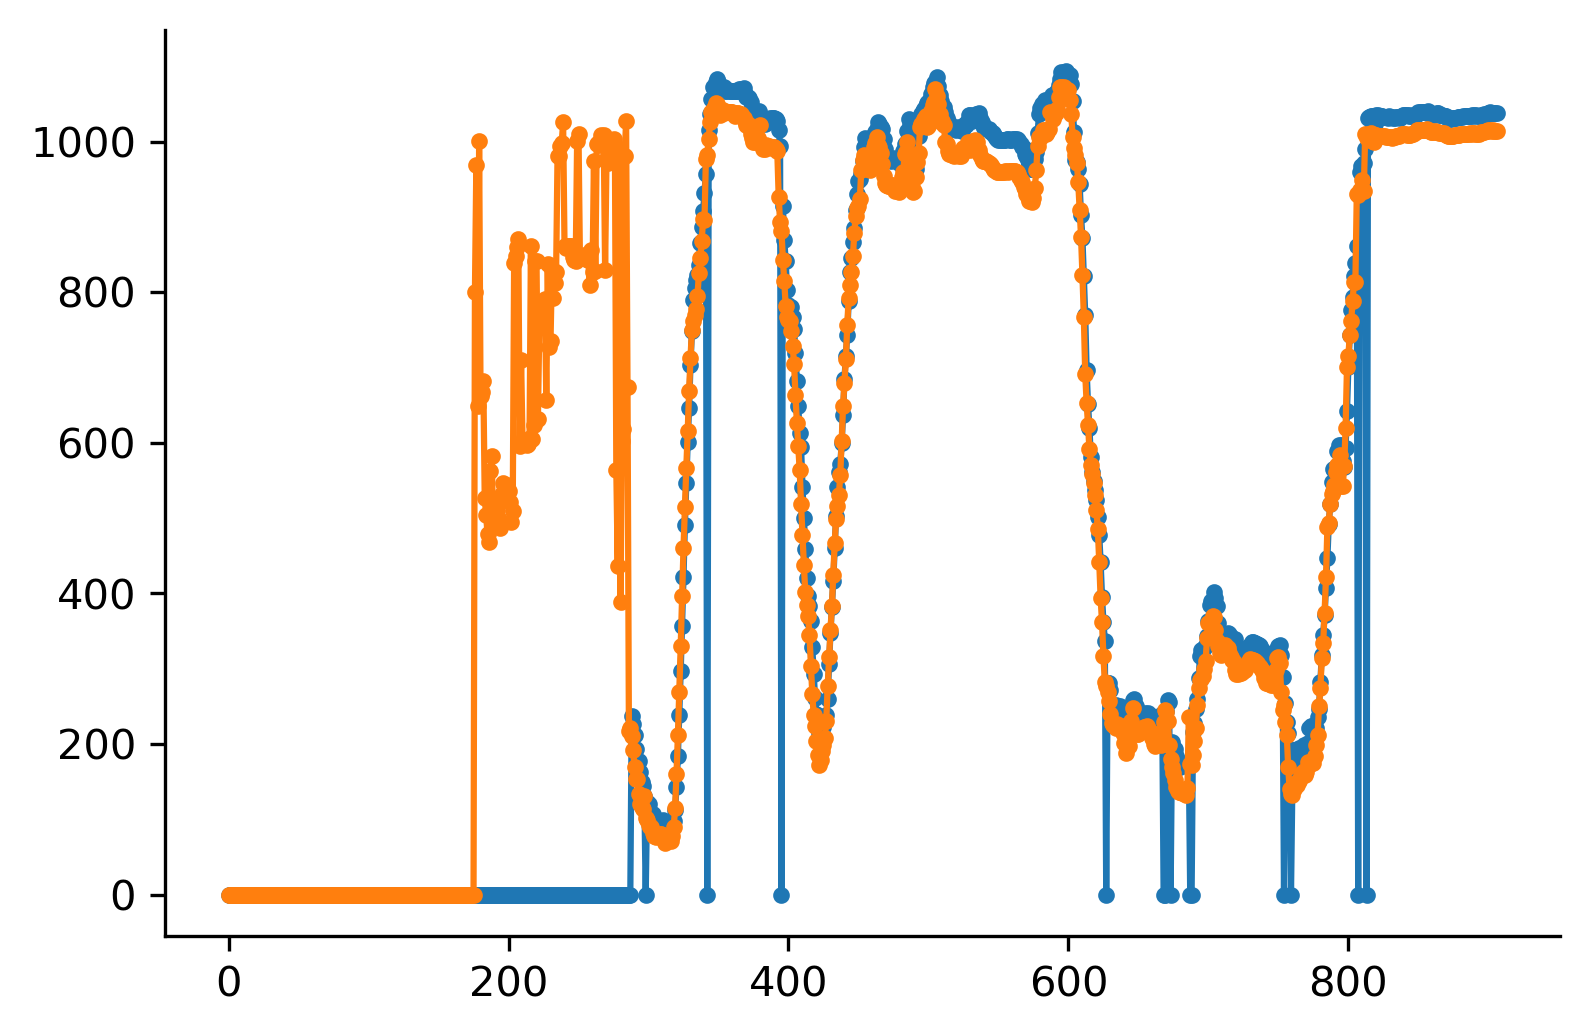

In [8]:
# Evaluate with single trials

# select the target trial
target_trial = 600

# load the corresponding data points
current_points = all_points[target_trial].loc[:, column_list].to_numpy()

# get the number of timepoints
number_timepoints = current_points.shape[0]

# allocate memory for the design matrix
design_matrix = np.zeros((number_timepoints, number_features*delay + number_features))
# pad the data according to the delay
current_points = np.concatenate((np.zeros((delay, number_features)), current_points), axis=0)
# assemble the design matrix
# for all the points
for points in np.arange(number_timepoints):
    design_matrix[points, :] = current_points[points:points+delay+1, :].reshape([1, -1])

    
# extract the prediction and validation matrices
design_matrix[np.isnan(design_matrix)] = 0

eval_X = design_matrix[:, number_features:]
eval_y = design_matrix[:, :number_features]
# predict the data
predicted_data = model.predict(eval_X)
# define the target variable
target_variable = 3
# plot against the real data
fp.plot_2d([[eval_y[:, target_variable], predicted_data[:, target_variable]]])
